# Notebook 2 - Extracting XYZ Coordinates from Vector Data
`GemGIS` is a Python-based, open-source geographic information processing library.
It is capable of preprocessing spatial data such as vector data (shape files, geojson files,
geopackages), raster data (tif, png,...), data obtained from web services (WMS, WFS, WCS) or XML/KML
files. Preprocessed data can be stored in a dedicated Data Class to be passed to the geomodeling package
`GemPy` (https://github.com/cgre-aachen/gempy) in order to accelerate to model building process. In addition, enhanced 3D visualization of data is
powered by the `PyVista` (https://github.com/pyvista/pyvista) package.

# Content

[Overview](#overview) <br>
[Load Libraries](#libraries) <br>
[What are Rasterio raster objects?](#rasters) <br>
[Example 1 - Rasterio Object](#ex1) <br>
[Example 2 - NumPy nd.array](#ex2) <br>
[Example 3 - Extract Data from any type of Geometry and any raster format](#ex3) <br>
[Summary](#summary) <br>


<a id='overview'></a>
# Overview

This notebook will present how to extract X and Y coordinates from vector data (shape files, geojsons, geopackages) loaded as GeoDataFrame using `GeoPandas` (https://github.com/geopandas/geopandas). This vector data consists of either `Point` data, `LineString` data, `MultiLineString` data or `Polygon` data. We will use a sample geological map to introduce the functionality of the different functions. The data was prepared in QGIS as shown below. The main difference to the previous tutorial is that elevation data wil be extracted using the `rasterio` package (https://github.com/mapbox/rasterio).

<img src="../data/Images/qgis.png" width="600">

The aim of this and the upcoming tutorials is to demonstrate how to prepare spatial data for geomodeling with `GemPy` to get a geological model like shown below. 

<img src="../data/Images/cover.png" width="600">

<a id='libraries'></a>
# Load Libraries

Firstly, we import the necessary libraries that we need for the extraction of X and Y coordinates. This includes the `GemGIS` library, `GeoPandas` to work with vector data and `Matplotlib` (https://github.com/matplotlib/matplotlib) for plotting. `Pandas` (https://github.com/pandas-dev/pandas) is needed for the manipulation of tables. `Rasterio` is the next package that will be utilized by `GemGIS`. The `NumPy` package will be used for numerical operations on arrays.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import numpy as np

import sys
sys.path.append('../../gemgis')
import gemgis as gg
print(gg.__version__)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


0.2.0


<a id='rasters'></a>
# What are Rasterio raster objects? 

Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

Properties of the raster data stored in a GeoTIFF can be accessed through attributes of the opened dataset object. Some of these attributes are shown below.

Source: https://rasterio.readthedocs.io/en/latest/

In [2]:
raster = rasterio.open('../data/Test1/raster1.tif')
raster

<open DatasetReader name='../data/Test1/raster1.tif' mode='r'>

In [3]:
raster.read(1)

array([[482.82904, 485.51953, 488.159  , ..., 618.8612 , 620.4424 ,
        622.05786],
       [481.6521 , 484.32193, 486.93958, ..., 618.8579 , 620.44556,
        622.06714],
       [480.52563, 483.18893, 485.80444, ..., 618.8688 , 620.4622 ,
        622.08923],
       ...,
       [325.49225, 327.21985, 328.94498, ..., 353.6889 , 360.03125,
        366.3984 ],
       [325.0538 , 326.78473, 328.51276, ..., 351.80603, 357.84106,
        363.96167],
       [324.61444, 326.34845, 328.0794 , ..., 350.09247, 355.87598,
        361.78635]], dtype=float32)

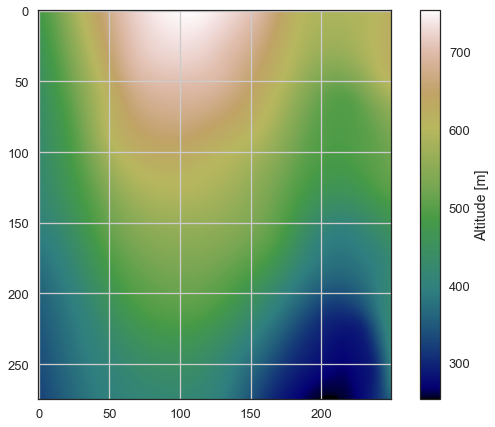

In [4]:
im = plt.imshow(raster.read(1), cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.grid()

In [5]:
raster.count

1

In [6]:
raster.width

250

In [7]:
raster.height

275

In [8]:
raster.bounds

BoundingBox(left=-4.440892098500626e-16, bottom=1.3642420526593924e-12, right=971.002897605575, top=1068.1031873661339)

In [9]:
raster.crs

CRS.from_epsg(4326)

In [10]:
raster.transform

Affine(3.8840115904223, 0.0, -4.440892098500626e-16,
       0.0, -3.8840115904223, 1068.1031873661339)

<a id='ex1'></a>
# Example 1 - Rasterio Object

## Load Data

As a first example to show how to extract X and Y coordinates from vector data, we are loading a shape file containing point information. Additional columns are `id`, which was not recorded when digitizing the data and `formation` indicating the base of the formation that was encountered at a particular point. This will become important in future tutorials. The term `Ton` is German for clay and indicates in this example the boundary between a sandstone layer and a claystone layer. The vector data is the same as used in the previous example.

In addition, we are loading a raster (tif-file) containing the elevation information of this area. The most important attributes of raster files were introduced above. 

Extracting X, Y and Z coordinates for LineStrings, MultiLineStrings and Polygons is working the same way as for points and will therefore not be introduced here. 

In [11]:
gdf = gpd.read_file('../data/Test1/interfaces1.shp')
gdf.head()

,id,formation,geometry
0,None,Ton,POINT (19.150 293.313)
1,None,Ton,POINT (61.934 381.459)
2,None,Ton,POINT (109.358 480.946)
3,None,Ton,POINT (157.812 615.999)
4,None,Ton,POINT (191.318 719.094)


## Plotting Data

The data can be plotted using the built-in `GeoPandas` plotting functions and by adding additional `Matplotlib` commands like grids or axes labels. To plot the raster and the input data points in one plot, a subplot is being created. The raster is extended to the size of the of the dimensions of the input data

Text(164.9569466791394, 0.5, 'Y [m]')

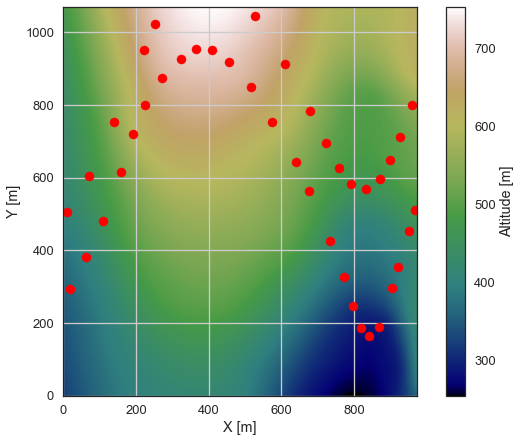

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(raster.read(1), cmap='gist_earth', extent=[0,972,0,1069])
gdf.plot(ax=ax, aspect='equal', color='red')

cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Extracting X, Y and Z Coordinates from a rasterio object

For the geomodeling with `GemPy` or other packages, the X, Y and Z coordinates of the `shapely` points need to be extracted from the vector and raster data. The extraction of the X and Y values for points was demonstrated in the previous example. To extract height data from a rasterio object, the `extract_xyz_rasterio` method of `GemGIS` is used. The manual way to extract elevation data would be to use the built-in `rasterio` `sample()` method and list comprehension as illustrated below.

The signature of the function is shown below:

```Signature:
gg.vector.extract_xyz_rasterio(
    gdf: geopandas.geodataframe.GeoDataFrame,
    dem: rasterio.io.DatasetReader,
    reset_index: bool = True,
    drop_index: bool = True,
    drop_id: bool = True,
    drop_points: bool = True,
    drop_level0: bool = True,
    drop_level1: bool = True,
) -> geopandas.geodataframe.GeoDataFrame
Docstring:
Extracting x, y coordinates from a GeoDataFrame (Points, LineStrings, MultiLineStrings Polygons) and z values from a
rasterio object and returning a GeoDataFrame with x, y, z coordinates as additional columns
Args:
    gdf (gpd.geodataframe.GeoDataFrame): GeoDataFrame created from vector data containing elements of type Point,
    LineString, MultiLineString or Polygon
    dem (rasterio.io.DatasetReader):  Rasterio object containing the height values
    reset_index (bool): Variable to reset the index of the resulting GeoDataFrame, default True
    drop_level0 (bool): Variable to drop the level_0 column, default True
    drop_level1 (bool): Variable to drop the level_1 column, default True
    drop_index (bool): Variable to drop the index column, default True
    drop_id (bool): Variable to drop the id column, default True
    drop_points (bool): Variable to drop the points column, default True
Return:
    gdf (gpd.geodataframe.GeoDataFrame): GeoDataFrame containing the X, Y and Z coordinates```

In [13]:
gdf_test = gg.vector.extract_xy(gdf)

In [14]:
gdf_test[['X', 'Y']].to_numpy()[:5]

array([[ 19.15012805, 293.31348536],
       [ 61.93436667, 381.45932637],
       [109.35786008, 480.94556798],
       [157.81229899, 615.99942965],
       [191.31802803, 719.09398054]])

In [15]:
z = [z[0] for z in raster.sample(gdf_test[['X', 'Y']].to_numpy())]
z[:5]

[364.99487, 400.3436, 459.54932, 525.69104, 597.6325]

## Extracting X, Y and Z coordinates using GemGIS

In its simplest version, `extract_xyz_rasterio` will return a `GeoDataFrame` with Points as geometry type, an additional `X`, `Y` and `Z` column and the remaining columns of the original `gdf`. The `id` column will be dropped by default as it is usally not used when creating the data in your GIS software.

In [16]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster)
gdf_coordinates.head()

,index,formation,geometry,X,Y,Z
0,0,Ton,POINT (19.150 293.313),19.15,293.31,364.99
1,1,Ton,POINT (61.934 381.459),61.93,381.46,400.34
2,2,Ton,POINT (109.358 480.946),109.36,480.95,459.55
3,3,Ton,POINT (157.812 615.999),157.81,616.00,525.69
4,4,Ton,POINT (191.318 719.094),191.32,719.09,597.63


An argument `reset_index=False` can be passed to prevent resetting the index. However, this will have no effect on `extract_xy_points` unless the data is cropped as shown below.

In [17]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, reset_index=False)
gdf_coordinates.head()

,formation,geometry,X,Y,Z
0,Ton,POINT (19.150 293.313),19.15,293.31,364.99
1,Ton,POINT (61.934 381.459),61.93,381.46,400.34
2,Ton,POINT (109.358 480.946),109.36,480.95,459.55
3,Ton,POINT (157.812 615.999),157.81,616.00,525.69
4,Ton,POINT (191.318 719.094),191.32,719.09,597.63


An argument `drop_id=False` can be passed to prevent dropping the `id` column if it is needed for further processing.

In [18]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, drop_id=False)
gdf_coordinates.head()

,index,id,formation,geometry,X,Y,Z
0,0,None,Ton,POINT (19.150 293.313),19.15,293.31,364.99
1,1,None,Ton,POINT (61.934 381.459),61.93,381.46,400.34
2,2,None,Ton,POINT (109.358 480.946),109.36,480.95,459.55
3,3,None,Ton,POINT (157.812 615.999),157.81,616.00,525.69
4,4,None,Ton,POINT (191.318 719.094),191.32,719.09,597.63


A `target_crs` can be provided with an EPSG code as string or a pyproj CRS object (https://pyproj4.github.io/pyproj/dev/api/crs/crs.html) to reproject the current coordinates into a different Coordinate Reference System (=CRS). As we deal with a Long/Lat coordinate system here, the reprojection will fail. Therefore, we pass the original CRS again.

In [19]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, target_crs='EPSG:4326')
gdf_coordinates.head()

,index,formation,geometry,X,Y,Z
0,0,Ton,POINT (19.150 293.313),19.15,293.31,364.99
1,1,Ton,POINT (61.934 381.459),61.93,381.46,400.34
2,2,Ton,POINT (109.358 480.946),109.36,480.95,459.55
3,3,Ton,POINT (157.812 615.999),157.81,616.00,525.69
4,4,Ton,POINT (191.318 719.094),191.32,719.09,597.63


A bounding box (`bbox`) containing `minx`, `maxx`, `miny`, `maxy` values can be provided to limit the extent of the data. The original `gdf` consists of 41 elements, the cropped `gdf_coordinates` of only 11 elements. Please notice, that the index was automatically reset. Passing `reset_index=False` will prevent resetting the index.

A clipping of the data can also be performed the same way for LineStrings, MultiLineStrings and Polygons but the demonstration of the feature will be limited to Point data here.

In [21]:
len(gdf)

41

In [22]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, reset_index=True, bbox = [600,850,150,700])
gdf_coordinates

,index,formation,geometry,X,Y,Z
0,13,Ton,POINT (638.748 641.773),638.75,641.77,548.81
1,14,Ton,POINT (674.831 563.421),674.83,563.42,510.37
2,15,Ton,POINT (734.111 426.305),734.11,426.31,423.21
3,16,Ton,POINT (771.740 327.335),771.74,327.33,368.95
4,17,Ton,POINT (795.968 245.890),795.97,245.89,317.00
5,18,Ton,POINT (818.648 185.580),818.65,185.58,288.32
6,19,Ton,POINT (841.329 164.961),841.33,164.96,281.77
7,33,Sand,POINT (723.286 693.836),723.29,693.84,513.16
8,34,Sand,POINT (757.307 626.824),757.31,626.82,489.19
9,35,Sand,POINT (790.297 583.525),790.30,583.52,467.02


In [23]:
len(gdf_coordinates)

11

The original data and the cropped/clipped data can now be visualized. The red rectangle marks the area that is being kept after the clipping. 

Text(432.7400645933013, 0.5, 'Y [m]')

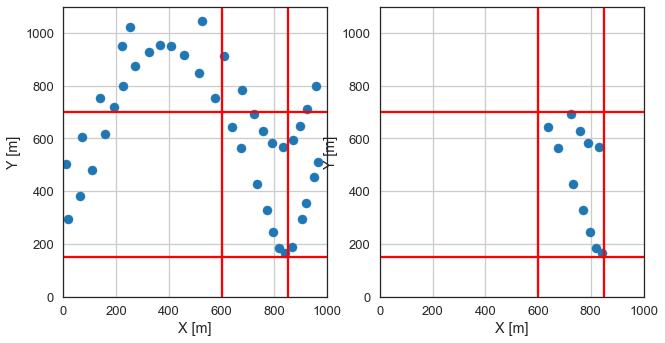

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
gdf.plot(ax=ax1, aspect='equal')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1100)
ax1.grid()

ax1.axhline(700, c='red')
ax1.axhline(150, c='red')
ax1.axvline(600, c='red')
ax1.axvline(850, c='red')
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')

gdf_coordinates.plot(ax=ax2, aspect='equal')
ax2.set_xlim(0,1000)
ax2.set_ylim(0,1100)
ax2.grid()

ax2.axhline(700, c='red')
ax2.axhline(150, c='red')
ax2.axvline(600, c='red')
ax2.axvline(850, c='red')
ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')

The index can also be reset but the old `index` column can be kept if needed for further processing.

In [25]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, reset_index=True, drop_index=False, bbox = [600,850,0,700])
gdf_coordinates

,index,formation,geometry,X,Y,Z
0,13,Ton,POINT (638.748 641.773),638.75,641.77,548.81
1,14,Ton,POINT (674.831 563.421),674.83,563.42,510.37
2,15,Ton,POINT (734.111 426.305),734.11,426.31,423.21
3,16,Ton,POINT (771.740 327.335),771.74,327.33,368.95
4,17,Ton,POINT (795.968 245.890),795.97,245.89,317.00
5,18,Ton,POINT (818.648 185.580),818.65,185.58,288.32
6,19,Ton,POINT (841.329 164.961),841.33,164.96,281.77
7,33,Sand,POINT (723.286 693.836),723.29,693.84,513.16
8,34,Sand,POINT (757.307 626.824),757.31,626.82,489.19
9,35,Sand,POINT (790.297 583.525),790.30,583.52,467.02


The index can also be kept when setting `reset_index=False`. 

In [26]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, reset_index=False, bbox = [600,850,0,700])
gdf_coordinates

,formation,geometry,X,Y,Z
13,Ton,POINT (638.748 641.773),638.75,641.77,548.81
14,Ton,POINT (674.831 563.421),674.83,563.42,510.37
15,Ton,POINT (734.111 426.305),734.11,426.31,423.21
16,Ton,POINT (771.740 327.335),771.74,327.33,368.95
17,Ton,POINT (795.968 245.890),795.97,245.89,317.00
18,Ton,POINT (818.648 185.580),818.65,185.58,288.32
19,Ton,POINT (841.329 164.961),841.33,164.96,281.77
33,Sand,POINT (723.286 693.836),723.29,693.84,513.16
34,Sand,POINT (757.307 626.824),757.31,626.82,489.19
35,Sand,POINT (790.297 583.525),790.30,583.52,467.02


In addition to limit the horizontal extent of the data, it is also possible to limit the data in its vertical extent using the arguments `minz` and `maxz`. 

In [27]:
gdf_coordinates = gg.vector.extract_xyz_rasterio(gdf, raster, minz=400, maxz=500)
gdf_coordinates

,index,formation,geometry,X,Y,Z
0,1,Ton,POINT (61.934 381.459),61.93,381.46,400.34
1,2,Ton,POINT (109.358 480.946),109.36,480.95,459.55
2,15,Ton,POINT (734.111 426.305),734.11,426.31,423.21
3,23,Ton,POINT (950.094 453.110),950.09,453.11,437.35
4,24,Ton,POINT (966.074 510.328),966.07,510.33,471.94
5,25,Sand,POINT (8.841 504.142),8.84,504.14,408.13
6,26,Sand,POINT (71.728 604.144),71.73,604.14,461.13
7,34,Sand,POINT (757.307 626.824),757.31,626.82,489.19
8,35,Sand,POINT (790.297 583.525),790.30,583.52,467.02
9,36,Sand,POINT (831.535 569.091),831.54,569.09,456.67


<a id='ex2'></a>
# Example 2 - NumPy nd.array

## Load Data

As a second example, we are loading the same shape file and the same raster but passing the raster as an `NumPy` nd.array instead of a `rasterio` object. This may be the case if the raster was interpolated from contour lines of a topographic map when XYZ data is provided in the ASCII format. The interpolation of rasters will be introduced in a later tutorial. 

In [28]:
gdf = gpd.read_file('../data/Test1/interfaces1.shp')
gdf.head()

,id,formation,geometry
0,None,Ton,POINT (19.150 293.313)
1,None,Ton,POINT (61.934 381.459)
2,None,Ton,POINT (109.358 480.946)
3,None,Ton,POINT (157.812 615.999)
4,None,Ton,POINT (191.318 719.094)


## Plotting Data

The data can be plotted using the built-in `GeoPandas` plotting functions and by adding additional `Matplotlib` commands like grids or axes labels. To plot the raster and the input data points in one plot, a subplot is being created. The raster is extended to the size of the of the dimensions of the input data

Text(164.9569466791394, 0.5, 'Y [m]')

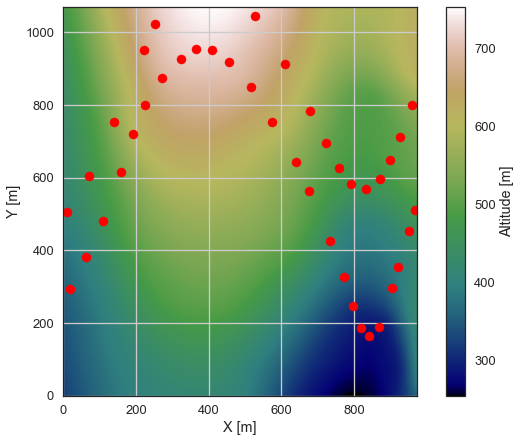

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(raster.read(1), cmap='gist_earth', extent=[0,972,0,1069])
gdf.plot(ax=ax, aspect='equal', color='red')

cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Extracting X, Y and Z Coordinates from a rasterio object

For the geomodeling with `GemPy` or other packages, the X, Y and Z coordinates of the `shapely` points need to be extracted from the vector and raster data. The extraction of the X and Y values for points was demonstrated in the previous example. To extract height data from a NumPy nd.array, the `extract_xyz_array` method of `GemGIS` is used. The manual way to extract elevation data would be to obtain the row and column number for a particular point in space and then getting the array value the calculated index. 

The signature of the function is shown below:

```Signature:
gg.vector.extract_xyz_array(
    gdf: geopandas.geodataframe.GeoDataFrame,
    dem: numpy.ndarray,
    extent: List[Union[int, float]],
    minz: float = None,
    maxz: float = None,
    reset_index: bool = True,
    drop_index: bool = True,
    drop_id: bool = True,
    drop_points: bool = True,
    drop_level0: bool = True,
    drop_level1: bool = True,
    target_crs: str = None,
    bbox: Union[Sequence[float], NoneType] = None,
) -> geopandas.geodataframe.GeoDataFrame
Docstring:
Extracting x, y coordinates from a GeoDataFrame (Points, LineStrings, MultiLineStrings Polygons) and z values from
a NumPy nd.array and returning a GeoDataFrame with x, y, z coordinates as additional columns
Args:
    gdf (gpd.geodataframe.GeoDataFrame): GeoDataFrame created from vector data containing elements of type Point,
    LineString, MultiLineString or Polygon
    dem (np.ndarray): NumPy ndarray containing the height values
    extent (list): List containing the extent of the np.ndarray, must be provided in the same CRS as the gdf
    minz (float): Value defining the minimum elevation the data needs to be returned, default None
    maxz (float): Value defining the maximum elevation the data needs to be returned, default None
    reset_index (bool): Variable to reset the index of the resulting GeoDataFrame, default True
    drop_level0 (bool): Variable to drop the level_0 column, default True
    drop_level1 (bool): Variable to drop the level_1 column, default True
    drop_index (bool): Variable to drop the index column, default True
    drop_id (bool): Variable to drop the id column, default True
    drop_points (bool): Variable to drop the points column, default True
    target_crs (str, pyproj.crs.crs.CRS): Name of the CRS provided to reproject coordinates of the GeoDataFrame
    bbox (list): Values (minx, maxx, miny, maxy) to limit the extent of the data
Return:
    gdf (gpd.geodataframe.GeoDataFrame): GeoDataFrame containing the X, Y and Z coordinates```

In [30]:
gdf_test = gg.vector.extract_xy(gdf)

In [31]:
array = raster.read(1)

In [32]:
extent = [0, 972, 0, 1069]

In [33]:
point_x = gdf_test['X'].values
point_x

array([ 19.15012805,  61.93436667, 109.35786008, 157.81229899,
       191.31802803, 224.82375707, 272.76272324, 323.27905318,
       366.0632918 , 407.81658491, 456.27102383, 515.03491783,
       575.34523011, 638.7483789 , 674.83147172, 734.11083848,
       771.74034955, 795.96756901, 818.64837021, 841.32917141,
       867.10280913, 903.70137469, 920.19650284, 950.0939226 ,
       966.07357798,   8.84067296,  71.728349  , 140.8016981 ,
       223.27733881, 253.17475857, 526.37531843, 608.85095914,
       677.92430824, 723.28591063, 757.30711243, 790.29736871,
       831.53518907, 869.6801729 , 898.54664715, 925.35123038,
       959.37243218])

In [34]:
point_y = gdf_test['Y'].values
point_y

array([ 293.31348536,  381.45932637,  480.94556798,  615.99942965,
        719.09398054,  798.47678472,  874.25127963,  927.34497334,
        952.60313831,  950.02577453,  917.550991  ,  847.96216915,
        753.63065509,  641.77306737,  563.42120869,  426.30545601,
        327.33468715,  245.88999195,  185.57967967,  164.9607695 ,
        188.15704345,  295.89084913,  355.17021589,  453.11003924,
        510.32751498,  504.14184193,  604.14355629,  751.56876407,
        950.54124729, 1022.70743291, 1045.38823411,  912.39626346,
        782.49712934,  693.83581557,  626.82435749,  583.52464612,
        569.09140899,  594.86504671,  648.47421318,  711.36188922,
        800.02320299])

In [35]:
# Getting the column number based on the extent and shape of the array
column = np.int32(np.round((point_x - extent[0]) / (extent[1] - extent[0]) * array.shape[1]))

# Getting the row number based on the extent and shape of the array
row = np.int32(np.round((point_y - extent[2]) / (extent[3] - extent[2]) * array.shape[0]))


In [36]:
row, column

(array([ 75,  98, 124, 158, 185, 205, 225, 239, 245, 244, 236, 218, 194,
        165, 145, 110,  84,  63,  48,  42,  48,  76,  91, 117, 131, 130,
        155, 193, 245, 263, 269, 235, 201, 178, 161, 150, 146, 153, 167,
        183, 206]),
 array([  5,  16,  28,  41,  49,  58,  70,  83,  94, 105, 117, 132, 148,
        164, 174, 189, 198, 205, 211, 216, 223, 232, 237, 244, 248,   2,
         18,  36,  57,  65, 135, 157, 174, 186, 195, 203, 214, 224, 231,
        238, 247]))

In [37]:
samples = array[row, column]
samples

array([446.1645 , 466.93005, 483.64307, 488.7129 , 476.3999 , 472.20084,
       463.56122, 454.35602, 449.52704, 448.96054, 451.31165, 462.0913 ,
       474.90082, 496.90717, 495.64478, 497.68134, 500.00635, 502.9575 ,
       526.3411 , 543.7136 , 540.34753, 509.83148, 508.79025, 506.04453,
       493.9116 , 417.4416 , 428.5653 , 433.4985 , 420.95636, 414.34186,
       386.19275, 378.1948 , 398.56604, 411.10126, 412.40036, 415.48093,
       417.29214, 410.2965 , 401.18286, 397.627  , 414.9521 ],
      dtype=float32)

## Extracting X, Y and Z coordinates using GemGIS

In its simplest version, `extract_xyz_array` will return a `GeoDataFrame` with Points as geometry type, an additional `X`, `Y` and `Z` column and the remaining columns of the original `gdf`. The `id` column will be dropped by default as it is usally not used when creating the data in your GIS software.

In [38]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069])
gdf_coordinates.head()

,formation,geometry,X,Y,Z
0,Ton,POINT (19.150 293.313),19.15,293.31,366.61
1,Ton,POINT (61.934 381.459),61.93,381.46,402.10
2,Ton,POINT (109.358 480.946),109.36,480.95,460.62
3,Ton,POINT (157.812 615.999),157.81,616.00,529.02
4,Ton,POINT (191.318 719.094),191.32,719.09,597.63


In [75]:
np.random.uniform(0, 10, 2)

len(gg.raster.sample_from_array(raster.read(1),extent=[0,972,0,1069], point_x=np.random.uniform(0, 10, 2), point_y=np.random.uniform(0, 10, 2)))

2

An argument `reset_index=False` can be passed to prevent resetting the index. However, this will have no effect on `extract_xy_points` unless the data is cropped as shown below.

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], reset_index=False)
gdf_coordinates.head()

An argument `drop_id=False` can be passed to prevent dropping the `id` column if it is needed for further processing.

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], drop_id=False)
gdf_coordinates.head()

A `target_crs` can be provided with an EPSG code as string or a pyproj CRS object (https://pyproj4.github.io/pyproj/dev/api/crs/crs.html) to reproject the current coordinates into a different Coordinate Reference System (=CRS). As we deal with a Long/Lat coordinate system here, the reprojection will fail. Therefore, we pass the original CRS again.

In [ ]:
gdf.crs

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], target_crs='EPSG:4326')
gdf_coordinates.head()

A bounding box (`bbox`) containing `minx`, `maxx`, `miny`, `maxy` values can be provided to limit the extent of the data. The original `gdf` consists of 41 elements, the cropped `gdf_coordinates` of only 11 elements. Please notice, that the index was automatically reset. Passing `reset_index=False` will prevent resetting the index.

A clipping of the data can also be performed the same way for LineStrings, MultiLineStrings and Polygons but the demonstration of the feature will be limited to Point data here.

In [ ]:
len(gdf)

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], reset_index=True, bbox = [600,850,150,700])
gdf_coordinates

In [ ]:
len(gdf_coordinates)

The original data and the cropped/clipped data can now be visualized. The red rectangle marks the area that is being kept after the clipping. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
gdf.plot(ax=ax1, aspect='equal')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1100)
ax1.grid()

ax1.axhline(700, c='red')
ax1.axhline(150, c='red')
ax1.axvline(600, c='red')
ax1.axvline(850, c='red')
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')

gdf_coordinates.plot(ax=ax2, aspect='equal')
ax2.set_xlim(0,1000)
ax2.set_ylim(0,1100)
ax2.grid()

ax2.axhline(700, c='red')
ax2.axhline(150, c='red')
ax2.axvline(600, c='red')
ax2.axvline(850, c='red')
ax2.set_xlabel('X [m]')
ax2.set_ylabel('Y [m]')

The index can also be reset but the old `index` column can be kept if needed for further processing.

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], reset_index=True, drop_index=False, bbox = [600,850,0,700])
gdf_coordinates

The index can also be kept when setting `reset_index=False`. 

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], reset_index=False, bbox = [600,850,0,700])
gdf_coordinates

In addition to limit the horizontal extent of the data, it is also possible to limit the data in its vertical extent using the arguments `minz` and `maxz`. 

In [ ]:
gdf_coordinates = gg.vector.extract_xyz_array(gdf,raster.read(1),extent=[0,972,0,1069], minz=400, maxz=500)
gdf_coordinates

<a id='ex3'></a>
# Extract XYZ from any type of Geometry and from Rasterio objects or arrays

**All introduced functions are combined to the function `extract_xyz(...)` taking the loaded vector data as GeoDataFrame and the raster as rasterio object or as array as input. In addition, the introduced arguments to drop columns, reproject the coordinates or clip the coordinates with a bounding box can be provided as well.**

<a id='summary'></a>
# Summary

In this tutorial it was shown how to 
- Extract XYZ coordinates from points and a rasterio object using `extract_xyz_rasterio()`
- Extract XYZ coordinates from points and a NumPy nd.array using `extract_xyz_array()`
- Explode XYZ coordinates from any type of geometry and any raster format using `extract_xyz()`

In the next tutorial, the functionality to clip data either bei providing a bounding box or a shapely polygon will be introduced.
